In [1]:
!nvidia-smi

Wed Nov 29 11:00:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   30C    P0    43W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install seaborn

     |████████████████████████████████| 292 kB 3.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install seaborn -U opencv-python

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.2)
     |████████████████████████████████| 92.1 MB 12.7 MB/s eta 0:00:01     |███████████████████▍            | 55.9 MB 19.9 MB/s eta 0:00:02
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for opencv-python: filename=opencv_python-4.8.1.78-cp36-cp36m-linux_x86_64.whl size=29207745 sha256=3447d9fd81767d1675878a43ca8a20040c5b30c5853040f7faa222530090c7fe
  Stored in directory: /root/.cache/pip/wheels/f7/f9/41/75b6091f85c8a1217adf7c43f1284b35aa285b8ca8708ddcec
Successfully built opencv-python
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:

from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install unzip
!unzip /content/data-20221211T082327Z-001.zip

In [10]:
pwd

'/workspace/data/RVO'

In [5]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset
# import glob
# training config:
epochs = 500
batch_size = 32

#define paths
rvo_path = "VCO_aug/1"
nonrvo_path = "VCO_aug/0"

# Use glob to grab images from path .jpg or jpeg
rvo_files = glob(rvo_path + '/*')
nonrvo_files = glob(nonrvo_path + '/*')

In [6]:
# Preparing Labels
rvo_labels = []
nonrvo_labels = []

rvo_images=[]
nonrvo_images=[]

import cv2

for i in range(len(rvo_files)):
  image = cv2.imread(rvo_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  rvo_images.append(image)
  rvo_labels.append('RVO')
for i in range(len(nonrvo_files)):
  image = cv2.imread(nonrvo_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  nonrvo_images.append(image)
  nonrvo_labels.append('NONRVO')

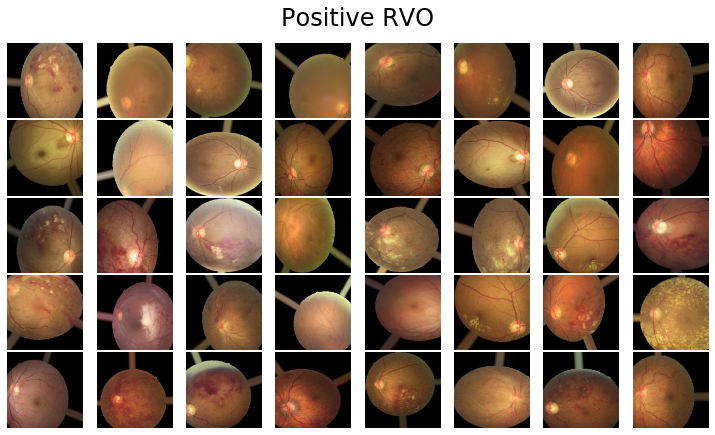

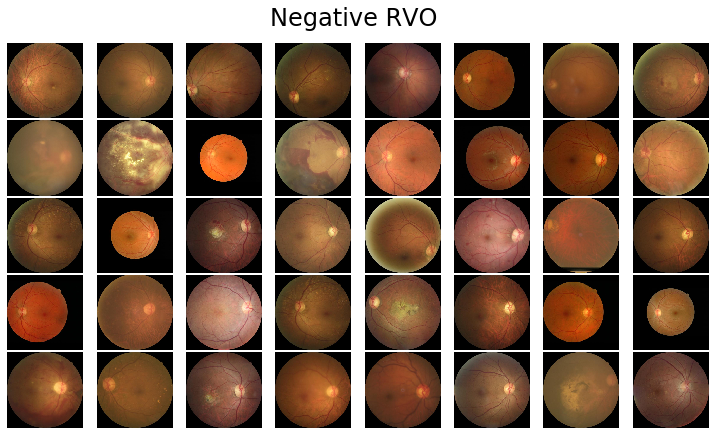

In [7]:

# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(rvo_images, 'Positive RVO')
plot_images(nonrvo_images, 'Negative RVO ')

In [8]:
# normalize to interval of [0,1]
rvo_images = np.array(rvo_images) / 255
rvocovid_images = np.array(nonrvo_images) / 255

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
rvo_x_train, rvo_x_test, rvo_y_train, rvo_y_test = train_test_split(
    rvo_images, rvo_labels, test_size=0.2)
nonrvo_x_train, nonrvo_x_test, nonrvo_y_train, nonrvo_y_test = train_test_split(
    nonrvo_images, nonrvo_labels, test_size=0.2)


X_train = np.concatenate((nonrvo_x_train, rvo_x_train), axis=0)
X_test = np.concatenate((nonrvo_x_test, rvo_x_test), axis=0)
y_train = np.concatenate((nonrvo_y_train, rvo_y_train), axis=0)
y_test = np.concatenate((nonrvo_y_test, rvo_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [10]:

# plot_images(rvo_x_train, 'X_train')
# plot_images(nonrvo_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

In [11]:

vgg = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step


In [12]:
# model = Model(inputs=resnet.input, outputs=prediction)
x = vgg.output
# x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(0.2)(x)

x = Flatten()(vgg.output)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

In [13]:
for layer in vgg.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


In [14]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=50)


Epoch 1/50
149/148 [==============================] - 60s 403ms/step - loss: 0.0291 - acc: 0.9916 - val_loss: 1.5391e-08 - val_acc: 1.0000
Epoch 2/50
149/148 [==============================] - 57s 383ms/step - loss: 2.7502e-10 - acc: 1.0000 - val_loss: 1.5391e-08 - val_acc: 1.0000
Epoch 3/50
149/148 [==============================] - 57s 384ms/step - loss: 5.0004e-10 - acc: 1.0000 - val_loss: 1.5391e-08 - val_acc: 1.0000
Epoch 4/50
149/148 [==============================] - 55s 372ms/step - loss: 4.2504e-10 - acc: 1.0000 - val_loss: 1.5391e-08 - val_acc: 1.0000
Epoch 5/50
149/148 [==============================] - 56s 373ms/step - loss: 2.5252e-09 - acc: 1.0000 - val_loss: 1.5391e-08 - val_acc: 1.0000
Epoch 6/50
149/148 [==============================] - 56s 375ms/step - loss: 5.2504e-10 - acc: 1.0000 - val_loss: 1.5391e-08 - val_acc: 1.0000
Epoch 7/50
149/148 [==============================] - 56s 373ms/step - loss: 3.7503e-10 - acc: 1.0000 - val_loss: 1.5391e-08 - val_acc: 1.0000
Epo

In [16]:
y_pred = model.predict(X_test, batch_size=batch_size)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


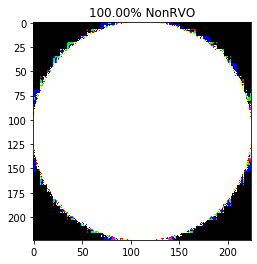

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


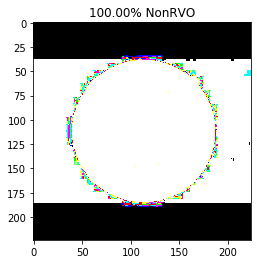

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


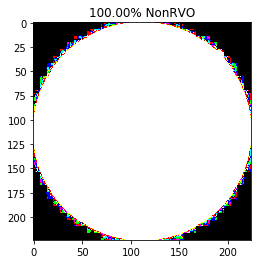

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


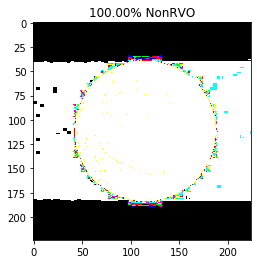

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


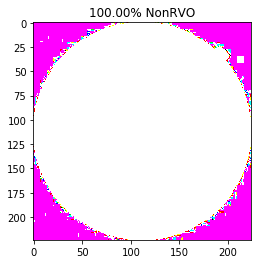

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


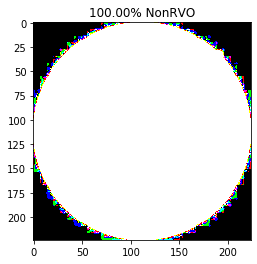

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


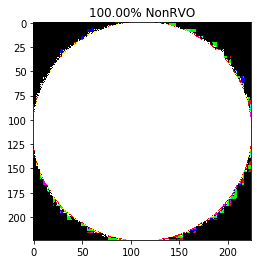

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


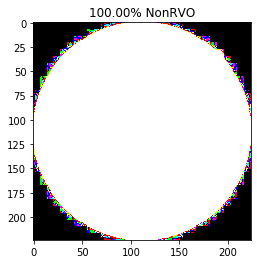

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


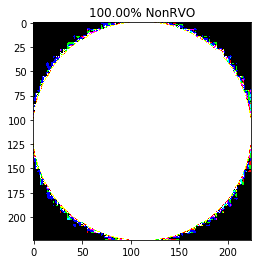

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


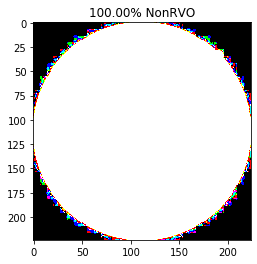

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


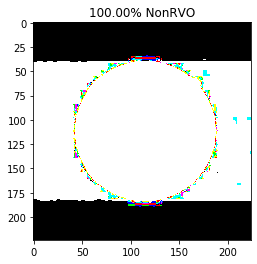

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


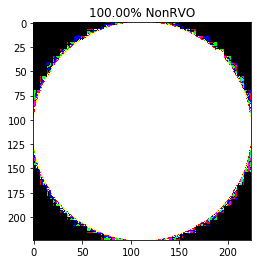

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


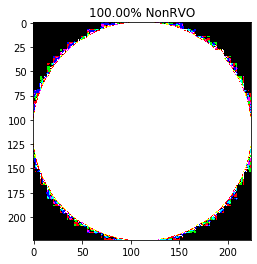

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


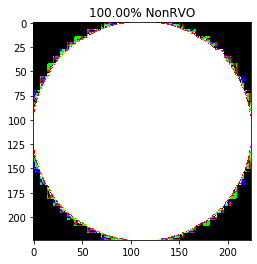

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


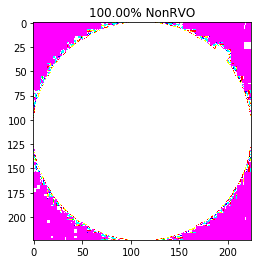

In [17]:
prediction=y_pred[0:15]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% RVO')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonRVO')
  plt.imshow(X_test[index])
  plt.show()


In [18]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

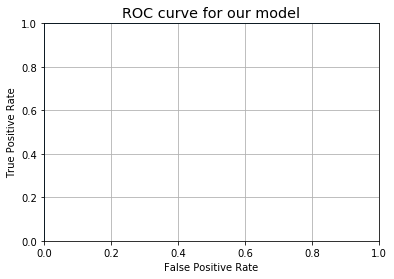

In [19]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


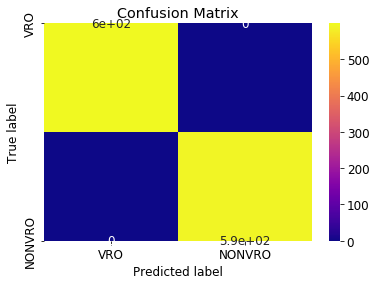

Confusion Matrix with Normalized Values


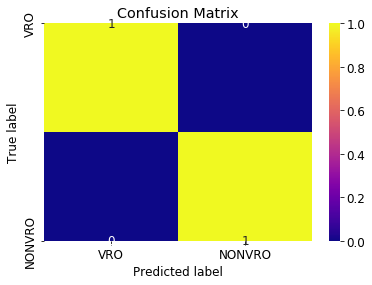

In [20]:
def plot_confusion_matrix(normalize):
  classes = ['VRO','NONVRO']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       599
           1       1.00      1.00      1.00       592

    accuracy                           1.00      1191
   macro avg       1.00      1.00      1.00      1191
weighted avg       1.00      1.00      1.00      1191



In [22]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_accuracy.png')
plt.show()

KeyError: 'accuracy'

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_chest_loss.png')
plt.show()


In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
img=image.load_img('/content/data/ASD/NYU_0050952_1.png',target_size=(224,224))

In [ ]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [ ]:
model.predict(img_data)

1/1 [==============================] - 1s 1s/step


array([[0., 1.]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 25ms/step


In [ ]:
a

array([1])